In [30]:
from astropy.io import fits
from astropy import units as u
import warnings
from specutils.fitting import find_lines_threshold
import glob
import numpy as np
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
import pandas as pd 
from specutils import Spectrum1D, SpectralRegion
from scripts import plot_tools as PL
from specutils.fitting import fit_generic_continuum
from specutils.fitting import find_lines_derivative
from specutils.fitting import fit_lines
from astropy.time import Time as tm
from specutils.manipulation import noise_region_uncertainty

import matplotlib.gridspec as gridspec


In [2]:
path = '/Users/amrutajaodand/Dropbox/PostDoc/Projects/emgw/AT2019wxt/wxt_optical/wxt_spectra'

hdul_path = "%s/gcn_AT2019wxt_2019-12-18_18-05-18_HCT-IIA_v2.fits"%path
hdul = fits.open(hdul_path)


In [3]:
hdr = hdul[0].header
hdr

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    1 / Number of axes                                 
NAXIS1  =                 2769 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2020-05-14T12:26:46' / Date FITS file was generated                  
IRAF-TLM= '2020-05-14T12:28:34' / Time of last modification                     
OBJECT  = 'PS19hgw '           / Name of the object observed                    
DATE-OBS= '        '           / Start of exposure                              
DATE_OBS= '        '           / Start of exposure                              
CREATOR = 'CCD3COMM'                                                            
OBSERVAT= 'IAO-HANLE'       

In [4]:
tnot = tm('2019-12-19 05:10:39', scale='utc')

tnot.mjd

58836.215729166666

In [5]:
filename = '/Users/amrutajaodand/Dropbox/PostDoc/Projects/emgw/AT2019wxt/wxt_optical/wxt_spectra/tns_2019wxt_2019-12-19_01-24-45_VLT-UT1_FORS2_adH0cc.txt'
spec_data = pd.read_csv(filename, header = None, delimiter = ' ')  
f_str = filename.split("/")[-1].split(".")[0]
f_str

'tns_2019wxt_2019-12-19_01-24-45_VLT-UT1_FORS2_adH0cc'

In [6]:
spec_data

,0,1
0,3379.227051,7.231975e-17
1,3382.520825,5.155827e-17
2,3385.814598,1.480248e-17
3,3389.108372,4.834542e-17
4,3392.402146,1.727332e-17
...,...,...
1895,9620.928420,1.245679e-17
1896,9624.222194,1.319845e-17
1897,9627.515968,1.209100e-17
1898,9630.809742,1.302636e-17


## Using lines threshold to find the spectral emission lines

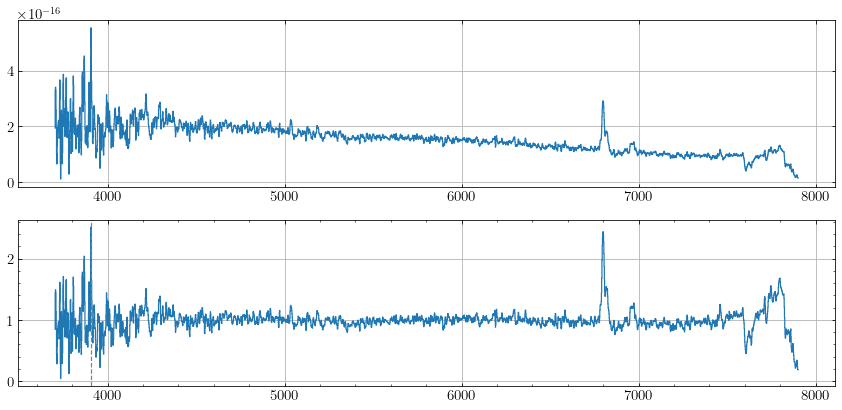

In [62]:
flux = spec_data[1].values * u.Unit('erg cm-2 s-1 AA-1')
lamb = spec_data[0].values * u.AA 

spec = Spectrum1D(spectral_axis=lamb, flux=flux)
fig = plt.figure() # create the canvas for plotting

ax1 = plt.subplot(2,1,1) 
ax1.step(spec.spectral_axis, spec.flux)

with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
    lines = find_lines_threshold(spec, noise_factor=2)
    
em_nr_lines = lines[lines['line_type'] == 'emission']  
PL.tick_par(plt)
ax1.grid(True)


ax2 = plt.subplot(2,1,2) 
ax2.step(spec_normalized.spectral_axis, spec_normalized.flux)
ax2.grid(True)

for i in em_nr_lines['line_center']:
    plt.axvline(i.value,ls='--', color='gray')
 

plt.gcf().set_size_inches(12,6)
plt.tight_layout()
plt.minorticks_on()
PL.tick_par(plt)
plt.savefig('Spectral_analysis/spectra_%s_noise_region_factor.pdf'%f_str)


## Using lines derivative to find the spectral emission lines

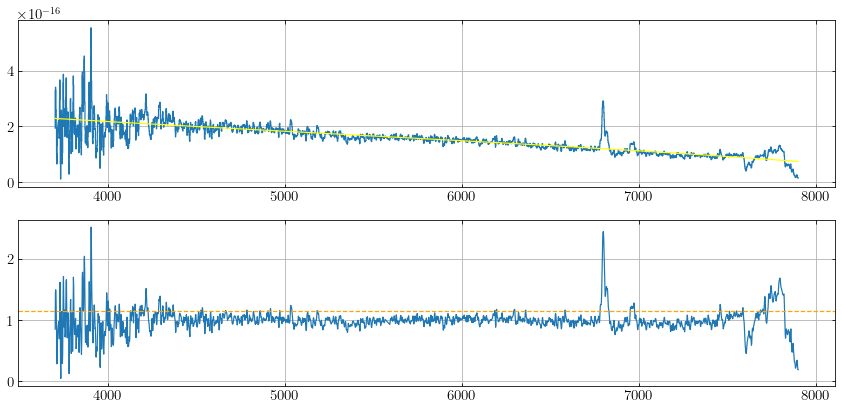

In [66]:
flux = spec_data[1].values * u.Unit('erg cm-2 s-1 AA-1')
lamb = spec_data[0].values * u.AA 
spec = Spectrum1D(spectral_axis=lamb, flux=flux)
fig = plt.figure() # create the canvas for plotting

ax1 = plt.subplot(2,1,1) 
ax1.step(spec.spectral_axis, spec.flux)

g1_fit = fit_generic_continuum(spec, exclude_regions=[SpectralRegion(3700 * u.AA, 4000 * u.AA),SpectralRegion(9300 * u.AA, 9500 * u.AA)])
y_continuum_fitted = g1_fit(spec.spectral_axis)

ax1.plot(lamb, y_continuum_fitted, color='yellow')
ax1.grid(True)
PL.tick_par(plt)

ax2 = plt.subplot(2,1,2) 
x_2 = spec.spectral_axis
y_2 = spec.flux


#fitting continuum (with exclude region 3700/4000 & H lines emission)
g_fit = fit_generic_continuum(spec, exclude_regions=[SpectralRegion(3700 * u.AA, 4000 * u.AA)])

#divide spectrum by its continuum
y_cont_fitted = g_fit(x_2)
spec_normalized = spec / y_cont_fitted

thresh = np.percentile(spec_normalized.flux,90) 
#we set the threshold at 90 by doing trial and error of which parameter bvalue seems to work best


#show on plot
ax2.plot(spec_normalized.spectral_axis, spec_normalized.flux)
ax2.axhline(thresh, ls = '--', color = 'orange')
ax2.grid(True)

plt.gcf().set_size_inches(12,6)
plt.tight_layout()
PL.tick_par(plt)
plt.savefig('Spectral_analysis/spectra_%s_continuum.pdf'%f_str)
plt.show()

In [67]:
from specutils.fitting import find_lines_derivative
from specutils.fitting import fit_lines

#Line fitting with Derivative technique
lines = find_lines_derivative(spec_normalized, flux_threshold=thresh)
em_lines = lines[lines['line_type'] == 'emission'] 
abs_lines  = lines[lines['line_type'] == 'absorption'] 

print('emission: ', em_lines) 

print('absorption: ', abs_lines) 


emission:   line_center  line_type line_center_index
   Angstrom                              
------------- --------- -----------------
3729.77617323  emission                17
3749.48736453  emission                30
3766.16606486  emission                41
3790.42599261  emission                57
3807.10469294  emission                68
3843.49458456  emission                92
3857.14079392  emission               101
3867.75451231  emission               108
3895.04693103  emission               126
 3907.1768949  emission               134
3923.85559523  emission               145
  3995.119133  emission               192
4002.70036042  emission               197
4011.79783332  emission               203
4042.12274301  emission               223
4064.86642528  emission               238
4140.67869949  emission               288
 4149.7761724  emission               294
4155.84115434  emission               298
4184.64981854  emission               317
4192.23104596  emission

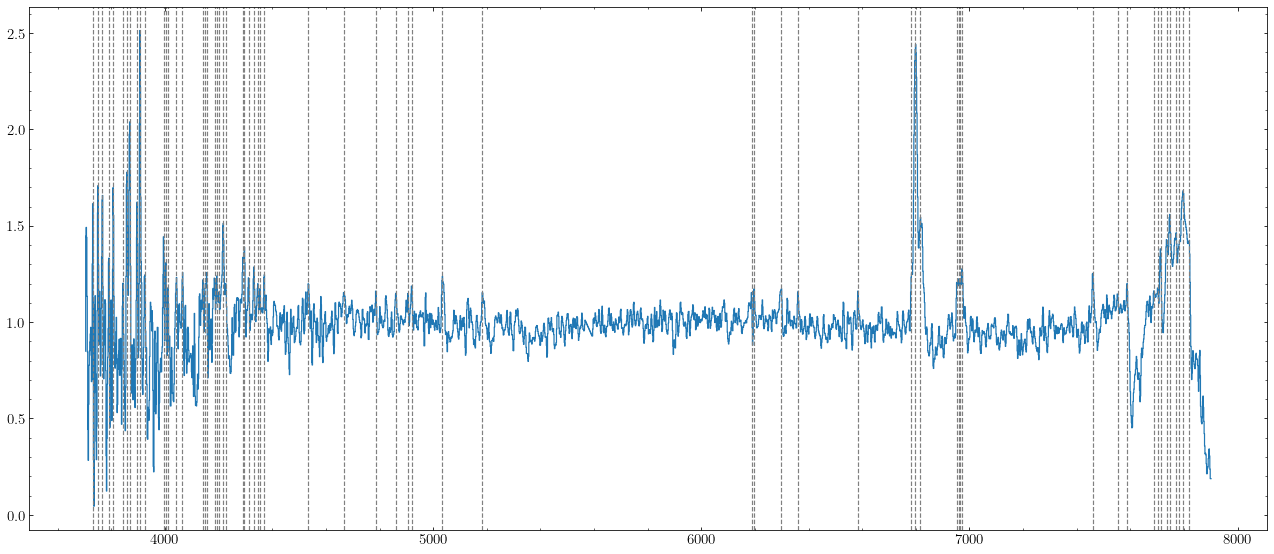

In [68]:
f, ax = plt.subplots()  
ax.step(spec_normalized.spectral_axis, spec_normalized.flux)

for i in em_lines['line_center']:
    plt.axvline(i.value,ls='--', color='gray')
 

plt.gcf().set_size_inches(18,8)
plt.tight_layout()
plt.minorticks_on()
PL.tick_par(plt)
plt.savefig('Spectral_analysis/spectra_%s.pdf'%f_str)

`**Of the two methods in our case the line derivatives seems to work better. So we are adopting it for the line identification**`

3431.92743173829 Angstrom
center :  3478.2669671814783 Angstrom
fwhm :  24.529170756710755 Angstrom


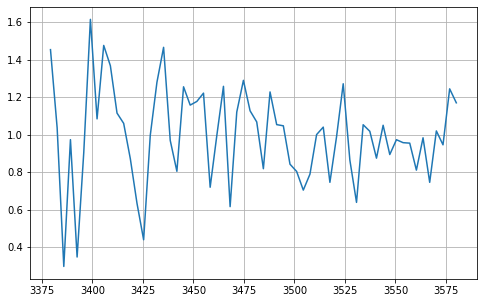

3474.74649126592 Angstrom
center :  3499.9388562181816 Angstrom
fwhm :  24.529170756710755 Angstrom


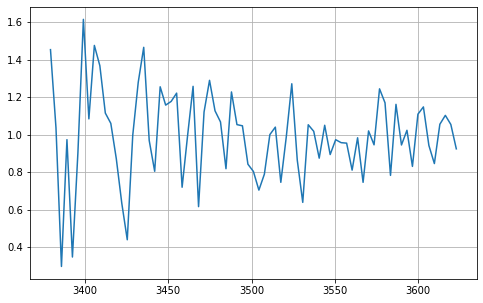

3487.92158650519 Angstrom
center :  3506.6674093040283 Angstrom
fwhm :  24.529170756710755 Angstrom


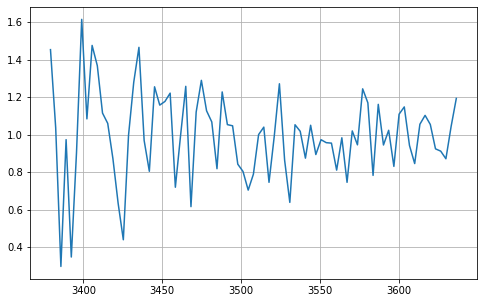

3576.85347937027 Angstrom
center :  3574.399025971242 Angstrom
fwhm :  29.55967187265105 Angstrom


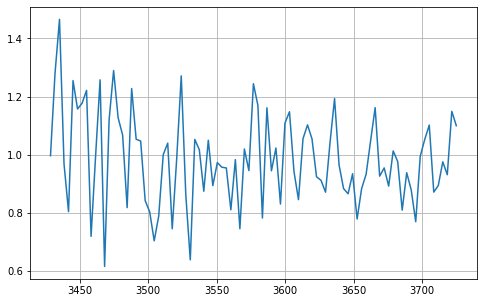

3721.77952700225 Angstrom
center :  3725.0191737042205 Angstrom
fwhm :  296.4396428835903 Angstrom


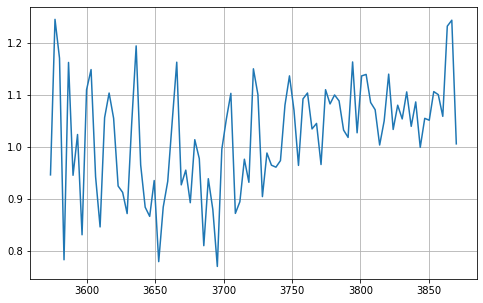

3863.41180082441 Angstrom
center :  3862.5278519019535 Angstrom
fwhm :  296.43964288359984 Angstrom


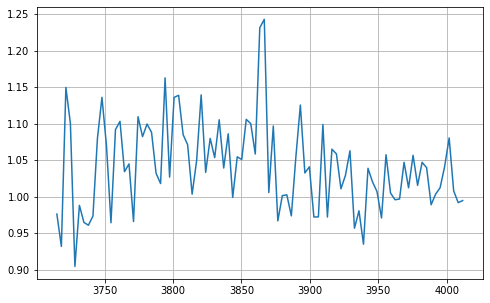

6798.16426537199 Angstrom
center :  6801.029078691395 Angstrom
fwhm :  296.43964288360075 Angstrom


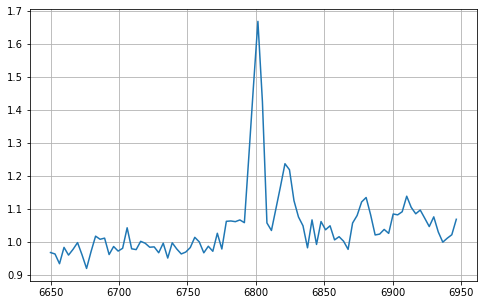

6821.22068204072 Angstrom
center :  6823.694445211182 Angstrom
fwhm :  296.43964288359075 Angstrom


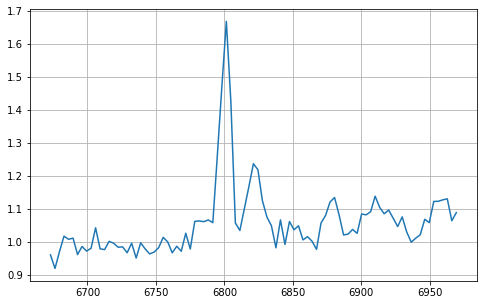

6877.21483680762 Angstrom
center :  6876.839178683081 Angstrom
fwhm :  296.43964288359984 Angstrom


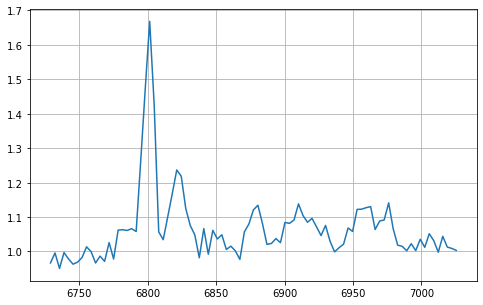

6910.1525749058 Angstrom
center :  6907.630434329276 Angstrom
fwhm :  296.43964288359075 Angstrom


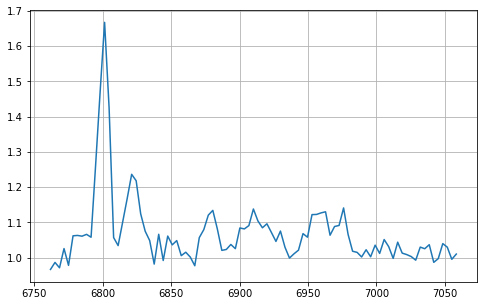

6959.55918205306 Angstrom
center :  6957.271724680384 Angstrom
fwhm :  296.43964288359984 Angstrom


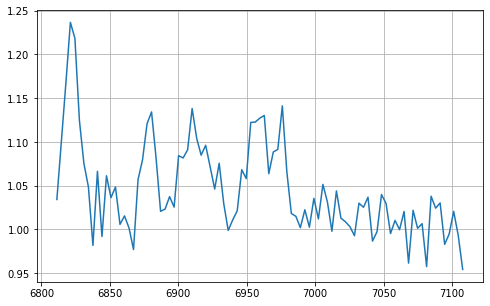

7611.72639639697 Angstrom
center :  7609.186383412145 Angstrom
fwhm :  296.43964288359984 Angstrom


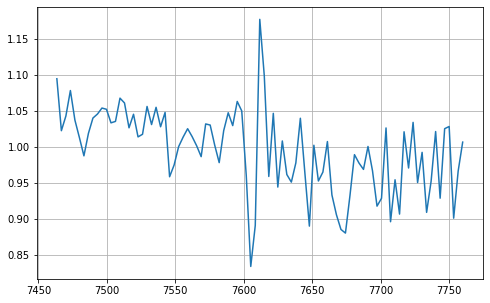

8777.72232507244 Angstrom
center :  8777.027527982133 Angstrom
fwhm :  296.43964288358984 Angstrom


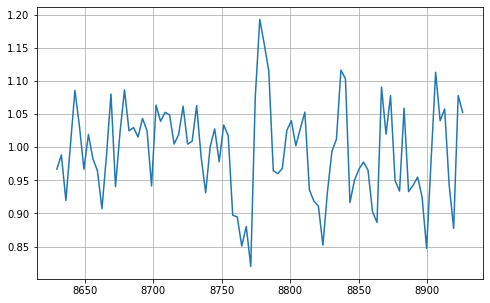

8837.01025364916 Angstrom
center :  8836.533616114231 Angstrom
fwhm :  296.43964288360075 Angstrom


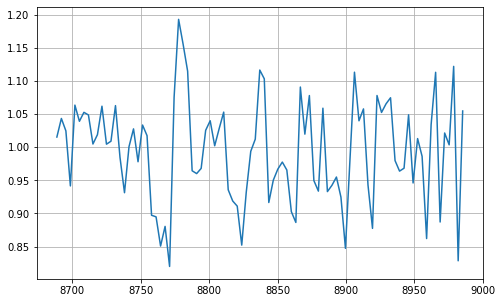

9041.22422985786 Angstrom
center :  9043.117547528496 Angstrom
fwhm :  296.43964288358984 Angstrom


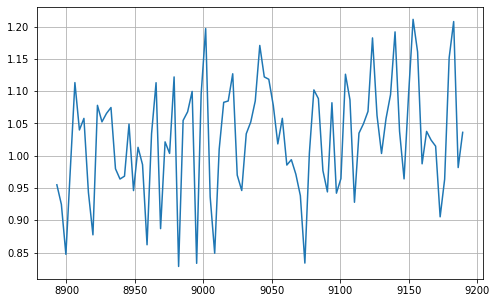

9103.80593224439 Angstrom
center :  9105.093251129987 Angstrom
fwhm :  296.43964288360075 Angstrom


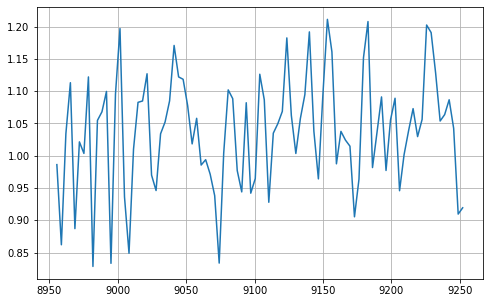

9153.21253939166 Angstrom
center :  9151.99057791142 Angstrom
fwhm :  296.43964288358984 Angstrom


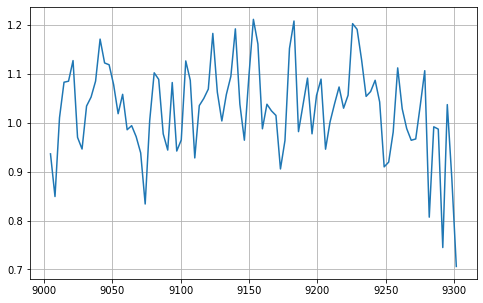

9179.5627298702 Angstrom
center :  9175.917858363742 Angstrom
fwhm :  296.43964288360075 Angstrom


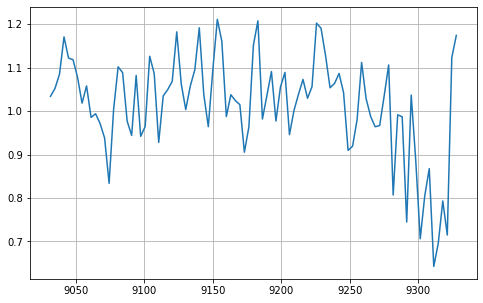

9225.67556320765 Angstrom
center :  9220.123358316561 Angstrom
fwhm :  296.43964288358984 Angstrom


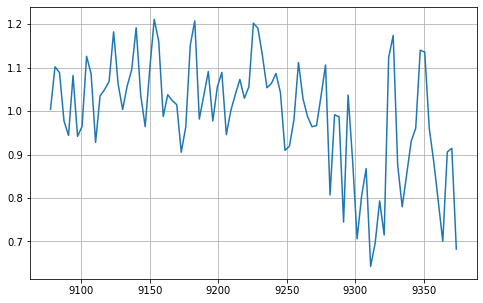

9324.48877750218 Angstrom
center :  9320.026259520142 Angstrom
fwhm :  255.21318112404333 Angstrom


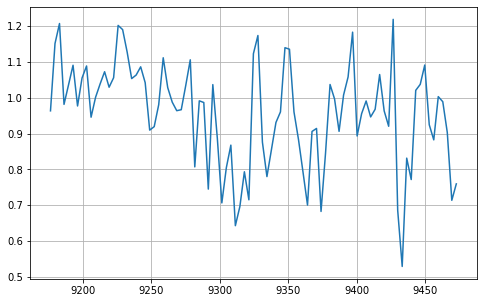

9347.5451941709 Angstrom
center :  9345.25482252817 Angstrom
fwhm :  232.15676445532335 Angstrom


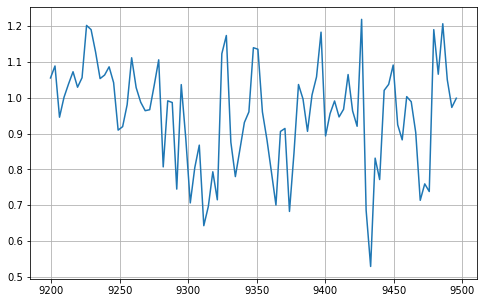

9479.29614656361 Angstrom
center :  9486.237336773995 Angstrom
fwhm :  151.34698863628728 Angstrom


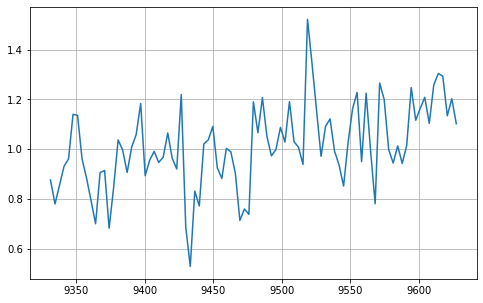

9505.64633704215 Angstrom
center :  9502.266046288663 Angstrom
fwhm :  157.93453625591792 Angstrom


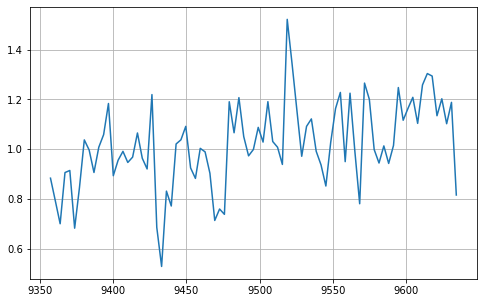

9518.82143228142 Angstrom
center :  9507.793174584647 Angstrom
fwhm :  157.93453625591792 Angstrom


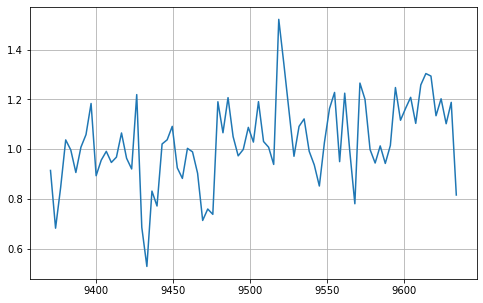

9551.7591703796 Angstrom
center :  9523.54765427691 Angstrom
fwhm :  157.93453625591792 Angstrom


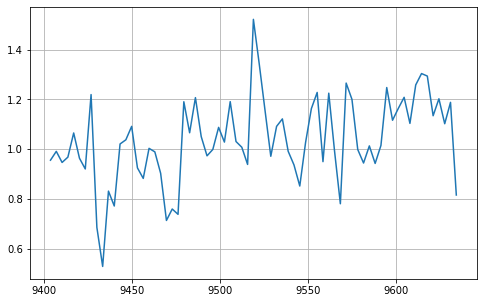

9571.52181323851 Angstrom
center :  9533.270830332855 Angstrom
fwhm :  157.93453625591792 Angstrom


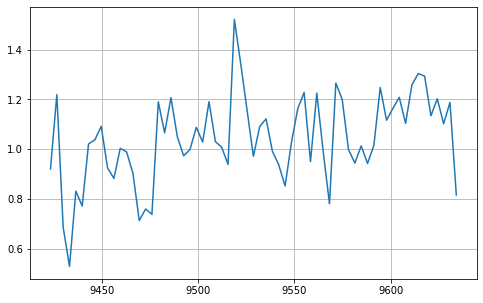

9614.34087276614 Angstrom
center :  9552.410885513786 Angstrom
fwhm :  157.93453625591792 Angstrom


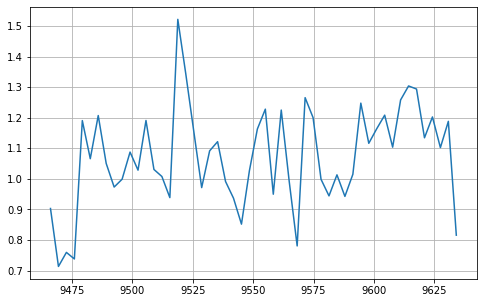

In [10]:
#import analysis tools
from specutils.manipulation import extract_region
from specutils.fitting import estimate_line_parameters
from specutils.analysis import centroid, fwhm

for i,l in enumerate(em_lines):
    print(l['line_center'])
    
    #create spectral region (after line detection of 6562.77A) +/- 50A
    sr =  SpectralRegion((l['line_center'].value-150)*u.AA, (l['line_center'].value+150)*u.AA)

    #print centroid - need a spectrum and a spectral region in parameters
    center = centroid(spec_normalized, sr)  
    print("center : ", center)

    #print fwhm - need a spectrum and a spectral region in parameters
    fwhm_spec = fwhm(spec_normalized, regions=sr)
    print("fwhm : ", fwhm_spec)

    #create a new spectrum of the selected region for plot
    sub_spectrum = extract_region(spec_normalized, sr)
    Ha_line = Spectrum1D(flux=sub_spectrum.flux,spectral_axis=sub_spectrum.spectral_axis)

    #plot
    fig12, ax12 = plt.subplots(figsize=(8,5))
    ax12.plot(Ha_line.spectral_axis, Ha_line.flux)
    ax12.grid(True)
    plt.show()

    
    

## Plotting them all together

In [11]:
files = glob.glob("%s/*.fits"%path)
print(files)

for f in files: 
    f_hdr = f.split("/")[-1][:-5]+'.txt'
    print(f_hdr[0:25])
    hdul = fits.open(f)
    hdr = hdul[0].header
    #np.savetxt("%s/%s"%(path,f_hdr),hdr, fmt='%s')

['/Users/amrutajaodand/Dropbox/PostDoc/Projects/emgw/AT2019wxt/wxt_optical/wxt_spectra/tns_2019wxt_2019-12-19_01-24-45_VLT-UT1_FORS2_adH0cc.fits', '/Users/amrutajaodand/Dropbox/PostDoc/Projects/emgw/AT2019wxt/wxt_optical/wxt_spectra/AT2019wxt_20191218_HCT_v1.fits', '/Users/amrutajaodand/Dropbox/PostDoc/Projects/emgw/AT2019wxt/wxt_optical/wxt_spectra/tns_2019wxt_2019-12-19_00-50-08_ESO-NTT_EFOSC2-NTT_ePESSTO+.fits', '/Users/amrutajaodand/Dropbox/PostDoc/Projects/emgw/AT2019wxt/wxt_optical/wxt_spectra/gcn_AT2019wxt_2019-12-18_18-05-18_HCT-IIA_v2.fits']
tns_2019wxt_2019-12-19_01
AT2019wxt_20191218_HCT_v1
tns_2019wxt_2019-12-19_00
gcn_AT2019wxt_2019-12-18_


In [12]:
def spectral_plotter_with_continuum(f): 
    spec_data = pd.read_csv(f, header = None, delimiter = ' ')  
    f_str = f.split("/")[-1].split(".")[0]
    f_str
    
    
    flux = spec_data[1].values * u.Unit('erg cm-2 s-1 AA-1')
    lamb = spec_data[0].values * u.AA 

    spec = Spectrum1D(spectral_axis=lamb, flux=flux)
    fig = plt.figure() # create the canvas for plotting


    ax1 = plt.subplot(2,1,1) 
    plt.title("%s"%f_str)

    ax1.step(spec.spectral_axis, spec.flux)
    g1_fit = fit_generic_continuum(spec)
    y_continuum_fitted = g1_fit(spec.spectral_axis)

    ax1.plot(lamb, y_continuum_fitted, color='orange')
    ax1.grid(True)

    ax2 = plt.subplot(2,1,2) 
    x_2 = spec.spectral_axis
    y_2 = spec.flux

    #fitting continuum (with exclude region 3700/4000 & H lines emission)
    g_fit = fit_generic_continuum(spec)

    #divide spectrum by his continuum
    y_cont_fitted = g_fit(x_2)
    spec_normalized = spec / y_cont_fitted
    
    #find theshold for line searches
    thresh = np.percentile(spec_normalized.flux, 90)
    
    #show on plot
    ax2.plot(spec_normalized.spectral_axis, spec_normalized.flux)
    
    em_lines, abs_lines = line_fitting(spec_normalized, thresh)
    
    for i in em_lines['line_center']:
        ax2.axvline(i.value,ls='--', color='gray')
    
    for i in abs_lines['line_center']:
        ax2.axvline(i.value,ls='--', color='green')
        
    ax2.axhline(thresh, ls = '--', color = 'orange')
    ax2.grid(True)
    
    plt.gcf().set_size_inches(12,6)
    plt.tight_layout
    plt.savefig('Spectral_analysis/spectra_%s_continuum.pdf'%f_str)
    plt.show()

    print(f_str)    

In [13]:
def line_fitting(spec_norm, thrsh):

    #Line fitting with Derivative technique
    lines = find_lines_derivative(spec_norm, flux_threshold=thrsh)
    e_l = lines[lines['line_type'] == 'emission'] 
    a_l  = lines[lines['line_type'] == 'absorption'] 

    return e_l, a_l


If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


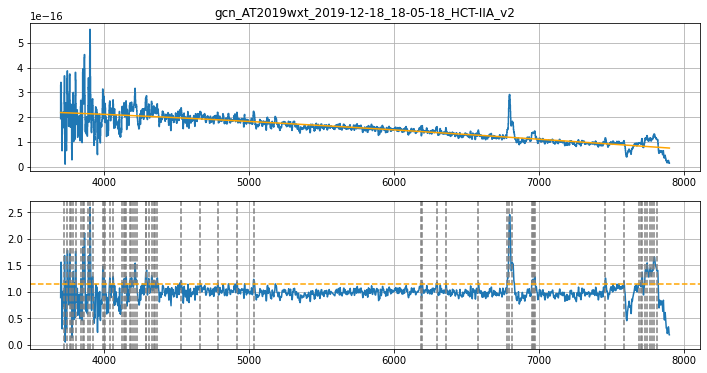

gcn_AT2019wxt_2019-12-18_18-05-18_HCT-IIA_v2



If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


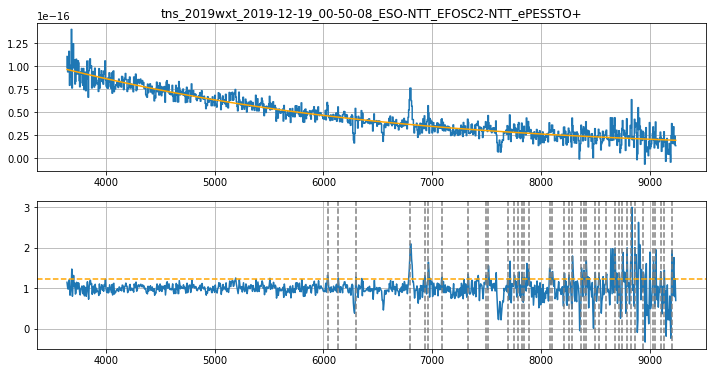

tns_2019wxt_2019-12-19_00-50-08_ESO-NTT_EFOSC2-NTT_ePESSTO+



If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


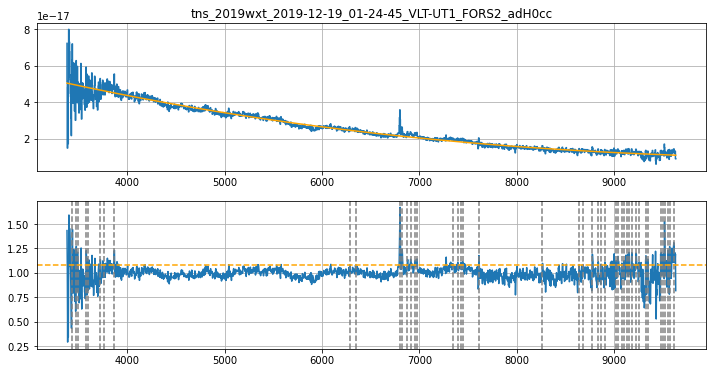

tns_2019wxt_2019-12-19_01-24-45_VLT-UT1_FORS2_adH0cc



If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


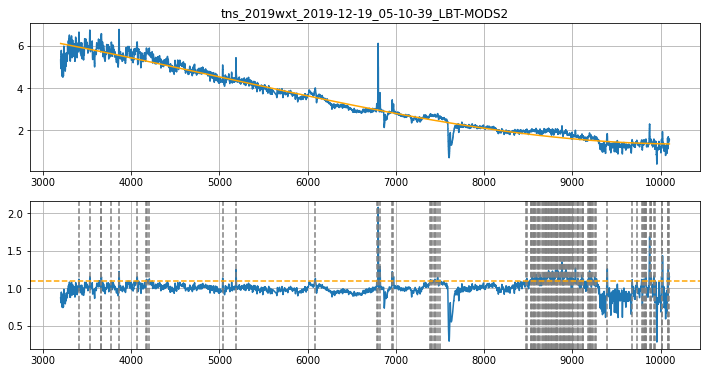

tns_2019wxt_2019-12-19_05-10-39_LBT-MODS2


In [14]:
files = sorted(glob.glob("%s/*.txt"%path))
Opt_mjds = sorted(np.array([58835.753, 58836.059, 58836.216, 58836.035]))
mjd_ref = 58833.305


for f in files: 
    spectral_plotter_with_continuum(f)

    

In [15]:


print(files, Opt_mjds)

['/Users/amrutajaodand/Dropbox/PostDoc/Projects/emgw/AT2019wxt/wxt_optical/wxt_spectra/gcn_AT2019wxt_2019-12-18_18-05-18_HCT-IIA_v2.txt', '/Users/amrutajaodand/Dropbox/PostDoc/Projects/emgw/AT2019wxt/wxt_optical/wxt_spectra/tns_2019wxt_2019-12-19_00-50-08_ESO-NTT_EFOSC2-NTT_ePESSTO+.txt', '/Users/amrutajaodand/Dropbox/PostDoc/Projects/emgw/AT2019wxt/wxt_optical/wxt_spectra/tns_2019wxt_2019-12-19_01-24-45_VLT-UT1_FORS2_adH0cc.txt', '/Users/amrutajaodand/Dropbox/PostDoc/Projects/emgw/AT2019wxt/wxt_optical/wxt_spectra/tns_2019wxt_2019-12-19_05-10-39_LBT-MODS2.txt'] [58835.753, 58836.035, 58836.059, 58836.216]


In [16]:
em_common_ls = []
def spectral_plotter(j,f): 
    spec_data = pd.read_csv(f, header = None, delimiter = ' ')  
    f_str = f.split("/")[-1].split(".")[0]
    
    f_str = f_str.split("_")[4]
    
    
    flux = spec_data[1].values * u.Unit('erg cm-2 s-1 AA-1')
    lamb = spec_data[0].values * u.AA 

    spec = Spectrum1D(spectral_axis=lamb, flux=flux)

        
    g1_fit = fit_generic_continuum(spec)
    y_continuum_fitted = g1_fit(spec.spectral_axis)

    x_2 = spec.spectral_axis
    y_2 = spec.flux

    #fitting continuum (with exclude region 3700/4000 & H lines emission)
    g_fit = fit_generic_continuum(spec)

    #divide spectrum by his continuum
    y_cont_fitted = g_fit(x_2)
    spec_normalized = spec/y_cont_fitted

    #plt.plot(spec_normalized.spectral_axis/(1+0.036), spec_normalized.flux/np.amax(spec_normalized.flux)+j, label = "%s"%f_str)

    plt.plot(spec.spectral_axis/(1+0.036), spec.flux/np.amax(spec.flux)+0.5*j+0.75, label = "%s"%f_str)
    #thresh = np.percentile(spec_normalized.flux, 95)
    
    thresh = np.percentile(y_2, 85)
    em_lines, abs_lines = line_fitting(spec, thresh)

    em_common_ls.append(em_lines[0][:])
    
    plt.annotate('+%3.2fd'%(Opt_mjds[j]-mjd_ref),xy=(np.max(spec.spectral_axis.value)-450, 1+0.55*j), fontsize=13)

    
    print(f_str)    
    

HCT-IIA
ESO-NTT



If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]

If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


VLT-UT1



If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]

If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


LBT-MODS2


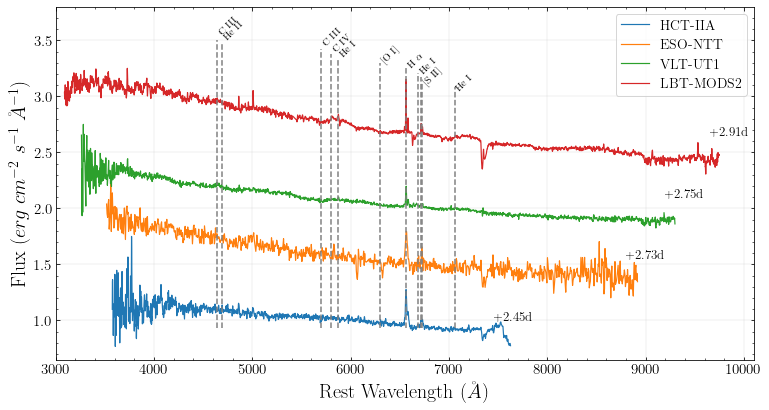

tns_2019wxt_2019-12-19_01-24-45_VLT-UT1_FORS2_adH0cc


In [17]:
# fig = plt.figure()

PL.plot_env()
for j,f in enumerate(files):
    spectral_plotter(j,f)
    
vline_arr = np.array([4640.759373, 4691.98388, 5703.302056, 5798.433292, 5874.538282, 6303.360598, 6562.410261, 6682.421969, 6717.547346, 6730.719363, 7057.092674])
annot = np.array(['C III', 'He II', 'C III', 'C IV', 'He I', '[O I]', r'H $\alpha$', 'He I', ''  , '[S II]', 'He I'])

for j,f in enumerate(vline_arr):
    
    
    plt.axvline(f,ls='--', lw='1.5', ymin = 0.09, ymax = (3.4-j*0.05)/3.75, color='gray')
    plt.annotate(annot[j],xy=(f, 3.55-j*0.05), rotation = 45, fontsize=10)    
    
    
plt.legend(loc = 1, prop={'size': 14})
plt.gcf().set_size_inches(11,6)
plt.ylim(0.65,3.8)
plt.xlim(3000,10100)
plt.xlabel(r'Rest Wavelength ($\AA$)', fontsize=20)
plt.ylabel(r'Flux ($erg~cm^{-2}~s^{-1}~\AA^{-1}$)',fontsize=20)
plt.minorticks_on()
plt.tight_layout()
PL.tick_par(plt)
plt.grid(True, color='#c1c1c1', linewidth=0.25)
plt.savefig('Spectral_analysis/Joint_Spectra_with_continuum.pdf')
plt.show()

print(f_str)    

#Add hrs apart 
#Add lines as panel b and panel c 
#Common lines vertical lines 
#Uncommon lines just label and leave 
#show a joint line 

In [18]:
def plot_sub_f(ax, fs):
    for j,f in enumerate(fs):
        spectral_plotter(j,f)

    vline_arr = np.array([4640.759373, 4691.98388, 5703.302056, 5798.433292, 5874.538282, 6303.360598, 6562.410261, 6682.421969, 6717.547346, 6730.719363, 7057.092674])
    annot = np.array(['C III', 'He II', 'C III', 'C IV', 'He I', '[O I]', r'H $\alpha$', 'He I', '[S II]', '[S II]', 'He I'])

    for j,f in enumerate(vline_arr):
        ax.axvline(f,ls='--', ymin = 0.09, ymax = (3.4-j*0.05)/3.75, color='gray')
        ax.annotate(annot[j],xy=(f, 3.55-j*0.05), rotation = 60, fontsize=8)    

    ax.grid(True)
    ax.set_xlabel(r'Rest Wavelength ($\AA$)')
    ax.set_ylabel(r'Flux ($erg~cm^{-2}~s^{-1}~\AA^{-1}$)')
    ax.minorticks_on()

HCT-IIA
ESO-NTT
VLT-UT1
LBT-MODS2
HCT-IIA
ESO-NTT
VLT-UT1
LBT-MODS2
HCT-IIA
ESO-NTT
VLT-UT1
LBT-MODS2
HCT-IIA
ESO-NTT
VLT-UT1
LBT-MODS2
HCT-IIA
ESO-NTT
VLT-UT1
LBT-MODS2


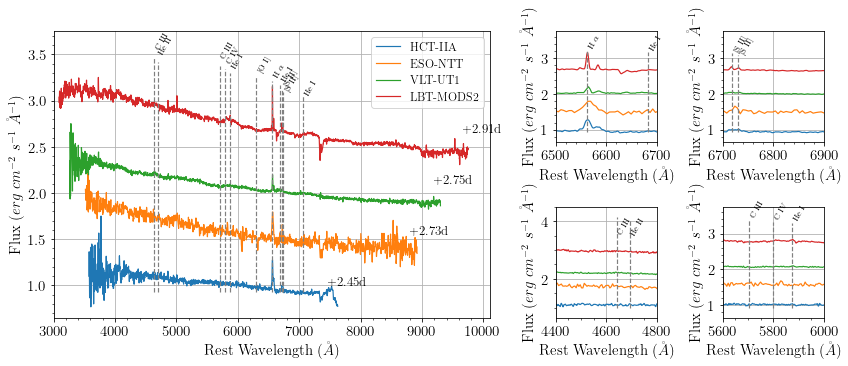

In [19]:
import warnings
warnings.filterwarnings("ignore")

fig = plt.figure(tight_layout=True)

gs01 = gridspec.GridSpec(4, 10, figure=fig)

ax1 = fig.add_subplot(gs01[0:,:-4])

PL.plot_env()
plot_sub_f(ax1, files)
ax1.set_ylim(0.65,3.75)
ax1.set_xlim(3000,10100)
ax1.legend(loc = 1, prop={'size': 12})


ax2 = fig.add_subplot(gs01[0:2, -4:-2])
plot_sub_f(ax2, files)
ax2.set_ylim(0.65,3.75)
ax2.set_xlim(6500,6700)

ax3 = fig.add_subplot(gs01[0:2, -2:])
plot_sub_f(ax3, files)
ax3.set_ylim(0.65,3.75)
ax3.set_xlim(6700,6900)


ax4 = fig.add_subplot(gs01[2:, -4:-2])
plot_sub_f(ax4, files)
ax4.set_ylim(0.65,4.5)
ax4.set_xlim(4400,4800)

ax5 = fig.add_subplot(gs01[2:, -2:])
plot_sub_f(ax5, files)
ax5.set_ylim(0.65,3.75)
ax5.set_xlim(5600,6000)

if i == 0:
    for tick in ax.get_xticklabels():
        tick.set_rotation(55)
fig.align_labels() 

plt.gcf().set_size_inches(12,5)
plt.savefig('Spectral_analysis/Joint_Spectra_with_continuum_subplanels.pdf')
plt.show()

In [ ]:
em_line_spread = []

for f in files: 
    
    plt.figure()
    spec_data = pd.read_csv(f, header = None, delimiter = ' ')  
    f_str = f.split("/")[-1].split(".")[0]
    f_str
    
    
    flux = spec_data[1].values * u.Unit('erg cm-2 s-1 AA-1')
    lamb = spec_data[0].values * u.AA 

    spec = Spectrum1D(spectral_axis=lamb, flux=flux)

        
    g1_fit = fit_generic_continuum(spec)
    y_continuum_fitted = g1_fit(spec.spectral_axis)

    x_2 = spec.spectral_axis
    y_2 = spec.flux

    #fitting continuum (with exclude region 3700/4000 & H lines emission)
    g_fit = fit_generic_continuum(spec)

    #divide spectrum by his continuum
    y_cont_fitted = g_fit(x_2)
    spec_normalized = spec / y_cont_fitted

    thresh = np.percentile(spec_normalized.flux, 95)
    
    em_lines, abs_lines = line_fitting(spec_normalized, thresh)
    
    for l in em_lines:
        #create spectral region (after line detection of 6562.77A) +/- 50A
        sr =  SpectralRegion((l['line_center'].value-50)*u.AA, (l['line_center'].value+50)*u.AA)

        #print centroid - need a spectrum and a spectral region in parameters
        center = centroid(spec_normalized, sr)  
        print("center : ", center)

        #print fwhm - need a spectrum and a spectral region in parameters
        fwhm_spec = fwhm(spec_normalized, regions=sr)
        print("fwhm : ", fwhm_spec)

        #create a new spectrum of the selected region for plot
        sub_spectrum = extract_region(spec_normalized, sr)
        L_spec = Spectrum1D(flux=sub_spectrum.flux,spectral_axis=sub_spectrum.spectral_axis)
            
        #plot
        fig12, ax12 = plt.subplots(figsize=(8,5))
        ax12.plot(L_spec.spectral_axis, L_spec.flux)

        ax12.axvline(l['line_center'].value,color='grey',ls='--')
        em_line_spread.append([l['line_center'].value,fwhm_spec.value])

        ax12.grid(True)
        
        #plt.savefig('%s/Spectral_analysis/lines%s.pdf'%(path,f_str)

center :  3742.482207432276 Angstrom
fwhm :  11.705215822630635 Angstrom
center :  3750.384483576045 Angstrom
fwhm :  11.705215822630635 Angstrom
center :  3766.8812300931154 Angstrom
fwhm :  11.705215822630635 Angstrom
center :  3788.6557383490335 Angstrom
fwhm :  11.705215822630635 Angstrom
center :  3805.2993346655753 Angstrom
fwhm :  7.940468033547859 Angstrom
center :  3859.7307117853265 Angstrom
fwhm :  18.204184827756308 Angstrom
center :  3871.957975292565 Angstrom
fwhm :  8.270015799274006 Angstrom
center :  3892.3016690220325 Angstrom
fwhm :  8.270015799274006 Angstrom
center :  3902.87954421949 Angstrom
fwhm :  8.270015799274006 Angstrom
center :  3996.4314222263906 Angstrom
fwhm :  38.64248035459423 Angstrom
center :  4005.387250312871 Angstrom
fwhm :  38.64248035459423 Angstrom
center :  4215.057952494112 Angstrom
fwhm :  74.91494510127359 Angstrom
center :  4296.517641265985 Angstrom
fwhm :  97.03971100000035 Angstrom
center :  4331.086927217087 Angstrom
fwhm :  97.039710

fwhm :  68.51770879099968 Angstrom
center :  9837.691842188682 Angstrom
fwhm :  90.19933612893146 Angstrom
center :  9876.058751274562 Angstrom
fwhm :  100.0 Angstrom
center :  9887.897369218246 Angstrom
fwhm :  98.42337228254291 Angstrom
center :  9919.309081758203 Angstrom
fwhm :  61.923372282542914 Angstrom


In [ ]:
files = sorted(glob.glob("%s/*.txt"%path))

em_s = []

for f in files: 
    em_l_spread = []

    spec_data = pd.read_csv(f, header = None, delimiter = ' ')  
    f_str = f.split("/")[-1].split(".")[0]
    f_str
    
    plt.figure(figsize=(20, 20))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle("Spectral_lines %s"%f_str, fontsize=14, y=0.95)
    
    flux = spec_data[1].values * u.Unit('erg cm-2 s-1 AA-1')
    lamb = spec_data[0].values * u.AA 

    spec = Spectrum1D(spectral_axis=lamb, flux=flux)

        
    g1_fit = fit_generic_continuum(spec)
    y_continuum_fitted = g1_fit(spec.spectral_axis)

    x_2 = spec.spectral_axis
    y_2 = spec.flux

    #fitting continuum (with exclude region 3700/4000 & H lines emission)
    g_fit = fit_generic_continuum(spec)

    #divide spectrum by his continuum
    y_cont_fitted = g_fit(x_2)
    spec_normalized = spec / y_cont_fitted

    thresh = np.percentile(spec_normalized.flux, 68)
    
    em_lines, abs_lines = line_fitting(spec_normalized, thresh)
    
    n_c=3
    
    n_r = int(np.ceil(len(em_lines)/n_c))
    
    for n,l in enumerate(em_lines):
        #create spectral region (after line detection of 6562.77A) +/- 50A
        sr =  SpectralRegion((l['line_center'].value-100)*u.AA, (l['line_center'].value+100)*u.AA)

        #print centroid - need a spectrum and a spectral region in parameters
        center = centroid(spec_normalized, sr)  
        print("center : ", center)

        #print fwhm - need a spectrum and a spectral region in parameters
        fwhm_spec = fwhm(spec_normalized, regions=sr)
        print("fwhm : ", fwhm_spec)

        #create a new spectrum of the selected region for plot
        sub_spectrum = extract_region(spec_normalized, sr)
        L_spec = Spectrum1D(flux=sub_spectrum.flux,spectral_axis=sub_spectrum.spectral_axis)
            
        #plot
        ax = plt.subplot(n_r, n_c, n+1)
        
        ax.plot(L_spec.spectral_axis, L_spec.flux)

        ax.axvline(l['line_center'].value,color='grey',ls='--')
        
        em_ln = l['line_center'].value-fwhm_spec.value
        em_lp = l['line_center'].value+fwhm_spec.value
        em_l_spread.append([l['line_center'].value,fwhm_spec.value,em_ln,em_lp])
        
        PL.tick_par(ax)
        ax.minorticks_on()
        ax.grid(True)
        np.savetxt('Spectral_analysis/lines_one_sig_%s.txt'%f_str,em_l_spread,fmt='%4.5f')
        
    em_s.append(em_l_spread)
    plt.tight_layout()
    plt.savefig('Spectral_analysis/lines_one_sig_%s.pdf'%(f_str))
    plt.show()

    

In [ ]:
for j,e in enumerate(em_s):
    f_str = files[j].split("/")[-1].split(".")[0]
    f_str
    
    np.savetxt('Spectral_analysis/lines_%s.txt'%f_str,e,fmt='%4.5f')

In [ ]:
files = sorted(glob.glob("%s/*.txt"%path))

abs_l_spread = []
abs_s = []

for f in files: 
    
    spec_data = pd.read_csv(f, header = None, delimiter = ' ')  
    f_str = f.split("/")[-1].split(".")[0]
    f_str
    
    plt.figure(figsize=(15, 15))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle("Spectral_lines %s"%f_str, fontsize=14, y=0.75)
    
    flux = spec_data[1].values * u.Unit('erg cm-2 s-1 AA-1')
    lamb = spec_data[0].values * u.AA 

    spec = Spectrum1D(spectral_axis=lamb, flux=flux)

        
    g1_fit = fit_generic_continuum(spec)
    y_continuum_fitted = g1_fit(spec.spectral_axis)

    x_2 = spec.spectral_axis
    y_2 = spec.flux

    #fitting continuum (with exclude region 3700/4000 & H lines emission)
    g_fit = fit_generic_continuum(spec)

    #divide spectrum by his continuum
    y_cont_fitted = g_fit(x_2)
    spec_normalized = spec / y_cont_fitted

    thresh = np.percentile(spec_normalized.flux, 95)
    
    em_lines, abs_lines = line_fitting(spec_normalized, thresh)
    
    n_c=3
    
    n_r = int(np.ceil(len(abs_lines)/n_c))
    
    for n,l in enumerate(abs_lines):
        #create spectral region (after line detection of 6562.77A) +/- 50A
        sr =  SpectralRegion((l['line_center'].value-50)*u.AA, (l['line_center'].value+50)*u.AA)

        #print centroid - need a spectrum and a spectral region in parameters
        center = centroid(spec_normalized, sr)  
        print("center : ", center)

        #print fwhm - need a spectrum and a spectral region in parameters
        fwhm_spec = fwhm(spec_normalized, regions=sr)
        print("fwhm : ", fwhm_spec)

        #create a new spectrum of the selected region for plot
        sub_spectrum = extract_region(spec_normalized, sr)
        L_spec = Spectrum1D(flux=sub_spectrum.flux,spectral_axis=sub_spectrum.spectral_axis)
            
        #plot
        ax = plt.subplot(n_r, n_c, n+1)
        
        ax.plot(L_spec.spectral_axis, L_spec.flux)

        ax.axvline(l['line_center'].value,color='grey',ls='--')
        abs_l_spread.append([l['line_center'].value,fwhm_spec.value])

        ax.grid(True)
    
    abs_s.append(abs_l_spread)
    plt.tight_layout()
    plt.savefig('Spectral_analysis/lines_absorption_%s.pdf'%(f_str))
    plt.show()

In [ ]:
from astroquery.nist import Nist


table = Nist.query(4850 * u.AA, 4870 * u.AA)



In [ ]:
table

In [ ]:
files = sorted(glob.glob("%s/*.txt"%path))
files

for f in files[0:1]: 
        p = pd.read_csv('Spectral_analysis/lines_%s.txt'%f_str, header=None, delimiter=r"\s+", usecols=(0,1,2,3))
        
        lin_list = []
        
        for j in range(len(p)):
            print(j,p[0][j])
            if p[1][j]<20:
                table = Nist.query((p[0][j]-30) * u.AA,  (p[0][j]+30)* u.AA)


In [ ]:
table